In [1]:
using LinearAlgebra;

using ForwardDiff;
using NLsolve;

using Plots;

## Linear FDM
We have previously discussed how to convert a second-order differential equation to a linear system of equations using the finite difference method. Two (linear) examples are shown below.
$$ \frac{\partial^2}{\partial x^2} u(x) = f(x) \implies A \mathbf{c} = \mathbf{f} $$
where $A$ is a tridiagonal matrix. With a variable diffusion coefficient $c(x)$, this becomes
$$ \frac{\partial}{\partial x} \left[ c(x) \frac{\partial u(x)}{\partial x} \right] = f(x) \implies A \mathbf{c} = \mathbf{f} $$
where $A$ is again tridiagonal, but can now be written as $A = B^T D B$, where $B$ represents the single derivative, and $D$ is a diagonal matrix containing the values of $c(x)$ evaluated at the nodes $x = x_i$.

### Residual and Jacobian
In preparation to solving non-linear differential equations, we can write the residual and Jacobian of this linear matrix equation as
\begin{align*}
    R(\mathbf{c}) & = A \mathbf{c} - \mathbf{f} \\
    J(\mathbf{c}) & = A \\
\end{align*}

In [2]:
# Construct the 1D mesh
N = 100; Np1 = N+1; h = 1 / N; h2 = h*h; 
x = Vector(0 : h : 1); 
xmid = x[1:end-1] .+ h / 2; 

# Define source and diffusion coefficient
f(x)    = (x > 0.25) * (x < 0.5);
cfun(x) = 1;

# Construct matrices
#  A: Double derivative in x direction
#  B and BT: Single derivative in x direction (on xmid)
#  D: Diagonal matrix with diffusion coefficient on xmid
#  F: Vector of source values on x
B  = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
D  = cfun.(xmid);

A = BT * Diagonal(D) * B;
F = f.(x); 

# Handle boundary conditions
A[1,1]       = 1;   A[1, 2]    = 0;   F[1]   = 0; 
A[end,end-1] = 0;   A[end,end] = 1;   F[end] = 0; 

# Construct residual and Jacobian
function res!(R, c) 
    R[:] = A * c - F;
end

function jac!(J, c)
    J[:] = A;
end

# Solve "non"-linear system
result = nlsolve(res!, jac!, zeros(size(x)), show_trace = :true)
u = result.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e+00              NaN
     1     1.099876e+00     4.082491e-05
     2     1.092456e+00     8.164986e-05
     3     1.039987e+00     1.632997e-04
     4     1.079191e+00     3.265995e-04
     5     1.054562e+00     6.531989e-04
     6     1.056100e+00     1.306398e-03
     7     1.047803e+00     2.612796e-03
     8     1.014522e+00     5.225591e-03
     9     9.961932e-01     1.045118e-02
    10     9.097985e-01     2.090237e-02
    11     7.834957e-01     4.180473e-02
    12     4.957907e-01     8.360946e-02
    13     2.273737e-13     1.485506e-01


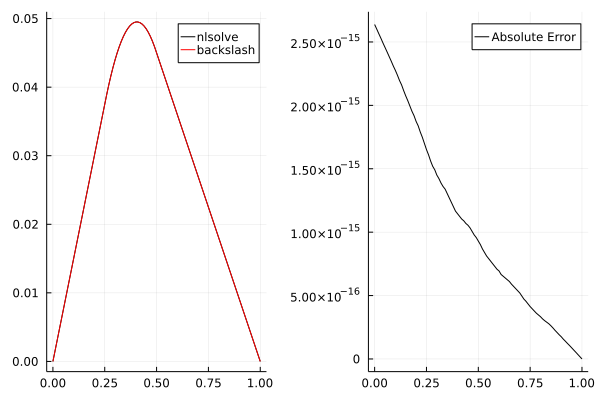

In [3]:
ulin = A \ F;

# Compare linear solve and nlsolve results
p1 = plot(x, u, color = :black, label = "nlsolve")
p1 = plot!(x, ulin, color = :red, label = "backslash")

p2 = plot(x, abs.(u - ulin), color = :black, label = "Absolute Error")

plot(p1, p2)

## Non-Linear FDM
Consider now the non-linear case where the matrix $A(\mathbf{c})$ is also a function of the unknown $\mathbf{c}$. TODO add examples of when this occurs?

In this case, the residual and Jacobian can be written as
\begin{align*}
    R(\mathbf{c}) & = A(\mathbf{c}) \cdot \mathbf{c} - \mathbf{f} \\
    J(\mathbf{c}) & = \frac{d R(\mathbf{c})}{d\mathbf{c}} = A(\mathbf{c}) + \frac{d A(\mathbf{c})}{d \mathbf{c}} \mathbf{c}
\end{align*}
Using the definition of $A = B^T D B$ for a variable diffusion coefficient as given for the linear case, the derivative of $A(\mathbf{c})$ becomes
$$ \frac{d A(\mathbf{c})}{d \mathbf{c}} = B^T \frac{d D}{d\mathbf{c}} B$$
where $D(\mathbf{c})$ encodes the variable diffusion coefficient as a function of $\mathbf{c}$.

### Calculating the Jacobian

### Using Automatic Differentiation

In [4]:
# Construct the 1D mesh
N = 100; Np1 = N+1; h = 1 / N; h2 = h*h; 
x = Vector(0 : h : 1); 
xmid = x[1:end-1] .+ h / 2; 

# Define source and diffusion coefficient
f(x) = 5e3 * (x > 0.25) * (x < 0.5);

a = 2.12e-4;
b = 7.358;
c = 1.18e6;
cfun(x, cx) = 1 / (4e-7 * pi) * (a + (1 - a) * cx^(2 * b) / (cx^(2 * b) + c));

# Construct matrices
#  A: Double derivative in x direction
#  B and BT: Single derivative in x direction (on xmid)
#  D: Diagonal matrix with diffusion coefficient on xmid
#  F: Vector of source values on x
B  = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));
D  = cfun.(xmid, zeros(size(xmid)));
    
A = BT * Diagonal(D) * B;
F = f.(x); 

# Handle boundary conditions
A[1,1]       = 1;   A[1, 2]    = 0;   F[1]   = 0; 
A[end,end-1] = 0;   A[end,end] = 1;   F[end] = 0; 

# Construct residual and Jacobian
function res!(R, c) 
    cx = abs.(B * c);
    D  = cfun.(xmid, cx);
    
    A = BT * Diagonal(D) * B;
    
    # Handle boundary conditions
    A[1,1]       = 1;   A[1, 2]    = 0;   F[1]   = 0; 
    A[end,end-1] = 0;   A[end,end] = 1;   F[end] = 0; 
    
    R[:] = A * c - F;
end

# Solve non-linear system using linear solution as initial guess
ulin   = A \ F;
result = nlsolve(res!, ulin, autodiff = :forward, show_trace = :true)
u = result.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.878192e+07              NaN
     1     6.863831e+08     2.543841e-16
     2     6.863831e+08     0.000000e+00
     3     5.009155e+08     2.359224e-16
     4     2.996640e+08     3.249448e-16
     5     1.947370e+08     2.482534e-16
     6     6.831468e+07     5.072735e-01
     7     3.184131e+08     2.501854e-16
     8     1.231213e+08     0.000000e+00
     9     5.741657e+07     2.680919e-01
    10     7.075780e+08     3.342214e-16
    11     3.985758e+08     1.110223e-16
    12     2.253970e+08     0.000000e+00
    13     5.691478e+07     6.795481e-02
    14     1.519341e+08     0.000000e+00
    15     5.229530e+07     5.927044e-02
    16     2.088058e+08     5.551115e-17
    17     5.149586e+07     0.000000e+00
    18     5.187215e+07     3.240761e-02
    19     4.805485e+07     6.313563e-02
    20     4.725991e+07     1.429438e-01
    21     4.680810e+08     5.551115e-17
    22     2.86326

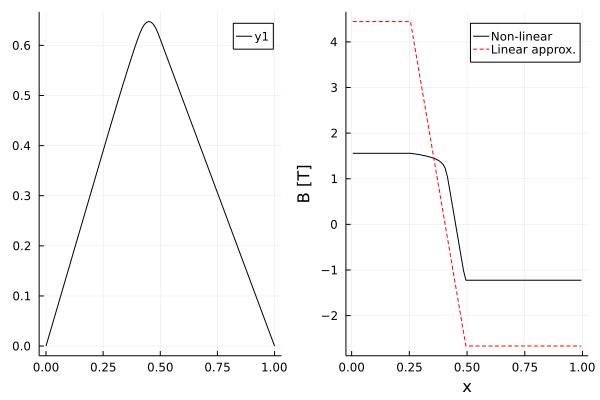

In [5]:
ux = B * u;

p1 = plot(x, u, color = :black)

p2 = plot(xmid, ux, color = :black, label = "Non-linear", xlabel = "x", ylabel = "B [T]")
p2 = plot!(xmid, B * ulin, color = :red, style = :dash, label = "Linear approx.")

plot(p1, p2)